# Trading Strategy Development for US/Mexico Currencies using Current A/C Deficit Data 



In [1]:
#Importing packages

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import matplotlib.lines as mlines
import statsmodels.formula.api as smf
import seaborn as sns
import yfinance as yf

In [3]:
#Exchange Rate data

ex = pd.read_csv("DEXMXUS.csv", index_col = 0, parse_dates = True)

ex.index = pd.to_datetime(ex.index)
ex.dtypes

mexico_ER    float64
US_ER          int64
dtype: object

In [4]:
#Resampling exchange rates to quarterly data 

ex = ex.resample('Q').first()

#Changing object type to float 
ex["mexico_ER"] = ex["mexico_ER"].astype("float")
ex["US_ER"] = ex["US_ER"].astype("float")
ex

,mexico_ER,US_ER
DATE,,
1999-12-31,9.4700,1.0
2000-03-31,9.4015,1.0
2000-06-30,9.2900,1.0
2000-09-30,9.5525,1.0
2000-12-31,9.4075,1.0
...,...,...
2015-12-31,16.8915,1.0
2016-03-31,17.3600,1.0
2016-06-30,17.3205,1.0


In [6]:
#US Current A/C Balance data

us = pd.read_excel("IEABC.xls", index_col = 0, parse_dates = True)
us.dropna(inplace = True)
us = us.iloc[2:,:]

In [24]:
us

,Unnamed: 1
FRED Graph Observations,
1999-01-01 00:00:00,-60838
1999-04-01 00:00:00,-67957
1999-07-01 00:00:00,-76129
1999-10-01 00:00:00,-81685
2000-01-01 00:00:00,-94772
...,...
2021-07-01 00:00:00,-226375
2021-10-01 00:00:00,-224837
2022-01-01 00:00:00,-282540


In [27]:
#Mexico Current A/C Balance data

mexico = pd.read_excel("BPBLTD01MXQ637S.xls", index_col = 0, parse_dates = True)
mexico.dropna(inplace = True)
mexico = mexico.iloc[2:,:]

In [30]:
#Merging Current Account Balance data for US and Mexico

df = pd.merge(us, mexico, left_index = True, right_index = True)
df.columns = ["USA", "Mexico"]
df.index.names = ["Date"]

In [31]:
#Converting index to DateTime object
df.index = pd.to_datetime(df.index)

#Changing object type to float for current a/c balance data
df["USA"] = df["USA"].astype("float")
df["Mexico"] = df["Mexico"].astype("float")
df

,USA,Mexico
Date,,
1999-01-01,-60838.0,-1.650200e+09
1999-04-01,-67957.0,-1.464800e+09
1999-07-01,-76129.0,-9.067000e+08
1999-10-01,-81685.0,-1.569400e+09
2000-01-01,-94772.0,-1.649000e+09
...,...,...
2015-10-01,-99657.0,-4.166200e+09
2016-01-01,-104015.0,-4.926000e+09
2016-04-01,-100481.0,-3.561100e+09


In [32]:
#Merging exchange rates data and current a/c balance data

df = pd.merge_asof(df, ex, left_index = True, right_index = True)
df.dropna(inplace = True)
data = df.copy()
data = data.iloc[:,:4]
data.columns = ["USA CAB", "MEX CAB", "MEX ER", "US ER"]
data

,USA CAB,MEX CAB,MEX ER,US ER
Date,,,,
2000-01-01,-94772.0,-1.649000e+09,9.4700,1.0
2000-04-01,-96392.0,-2.175000e+09,9.4015,1.0
2000-07-01,-104474.0,-2.123700e+09,9.2900,1.0
2000-10-01,-106279.0,-2.417500e+09,9.5525,1.0
2001-01-01,-107136.0,-2.687500e+09,9.4075,1.0
...,...,...,...,...
2015-10-01,-99657.0,-4.166200e+09,15.7780,1.0
2016-01-01,-104015.0,-4.926000e+09,16.8915,1.0
2016-04-01,-100481.0,-3.561100e+09,17.3600,1.0


In [33]:
#Taking differential of Current A/C Balance of the two countries
data["Differential"] = data["USA CAB"]-data["MEX CAB"]
data

,USA CAB,MEX CAB,MEX ER,US ER,Differential
Date,,,,,
2000-01-01,-94772.0,-1.649000e+09,9.4700,1.0,1.648905e+09
2000-04-01,-96392.0,-2.175000e+09,9.4015,1.0,2.174904e+09
2000-07-01,-104474.0,-2.123700e+09,9.2900,1.0,2.123596e+09
2000-10-01,-106279.0,-2.417500e+09,9.5525,1.0,2.417394e+09
2001-01-01,-107136.0,-2.687500e+09,9.4075,1.0,2.687393e+09
...,...,...,...,...,...
2015-10-01,-99657.0,-4.166200e+09,15.7780,1.0,4.166100e+09
2016-01-01,-104015.0,-4.926000e+09,16.8915,1.0,4.925896e+09
2016-04-01,-100481.0,-3.561100e+09,17.3600,1.0,3.561000e+09


In [34]:
#Calculating Returns
data["Returns"] = np.log(data["MEX ER"]).diff()

data

,USA CAB,MEX CAB,MEX ER,US ER,Differential,Returns
Date,,,,,,
2000-01-01,-94772.0,-1.649000e+09,9.4700,1.0,1.648905e+09,NaN
2000-04-01,-96392.0,-2.175000e+09,9.4015,1.0,2.174904e+09,-0.007260
2000-07-01,-104474.0,-2.123700e+09,9.2900,1.0,2.123596e+09,-0.011931
2000-10-01,-106279.0,-2.417500e+09,9.5525,1.0,2.417394e+09,0.027864
2001-01-01,-107136.0,-2.687500e+09,9.4075,1.0,2.687393e+09,-0.015296
...,...,...,...,...,...,...
2015-10-01,-99657.0,-4.166200e+09,15.7780,1.0,4.166100e+09,0.043061
2016-01-01,-104015.0,-4.926000e+09,16.8915,1.0,4.925896e+09,0.068194
2016-04-01,-100481.0,-3.561100e+09,17.3600,1.0,3.561000e+09,0.027358


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


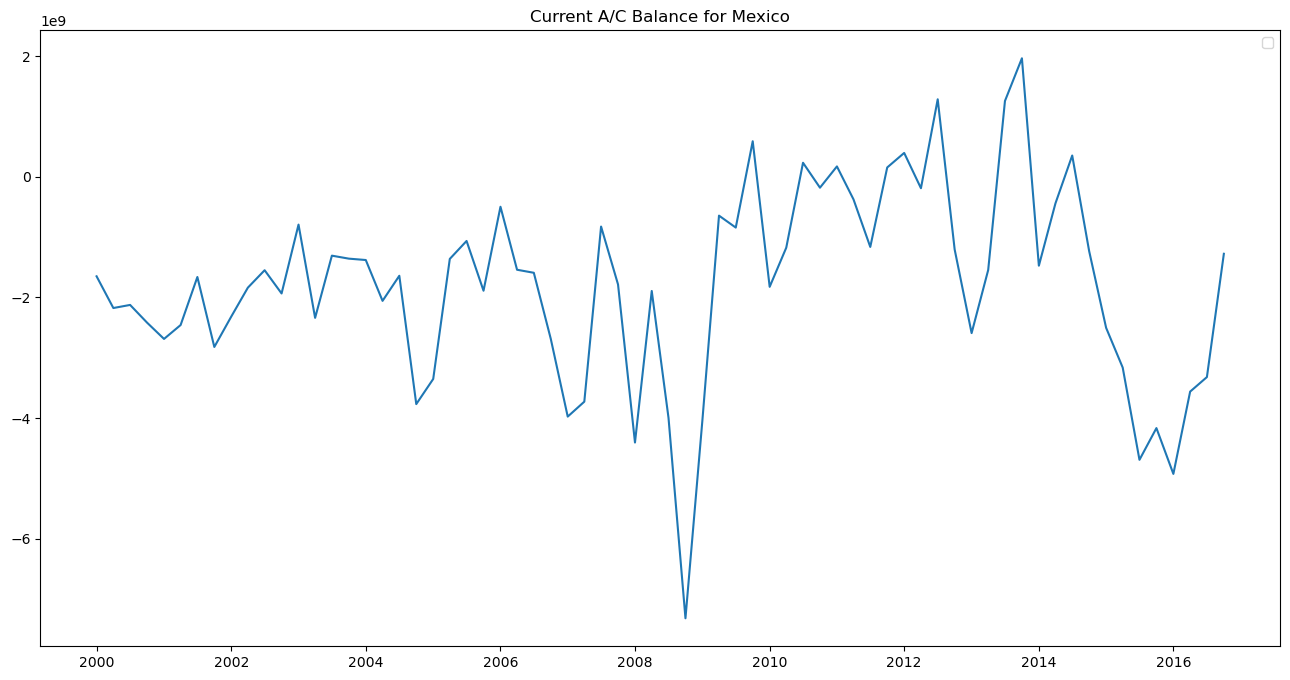

In [35]:
#Visualising Current A/C Balance for Mexico
plt.figure(figsize = (16, 8))
plt.plot(data["MEX CAB"])
plt.title("Current A/C Balance for Mexico")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


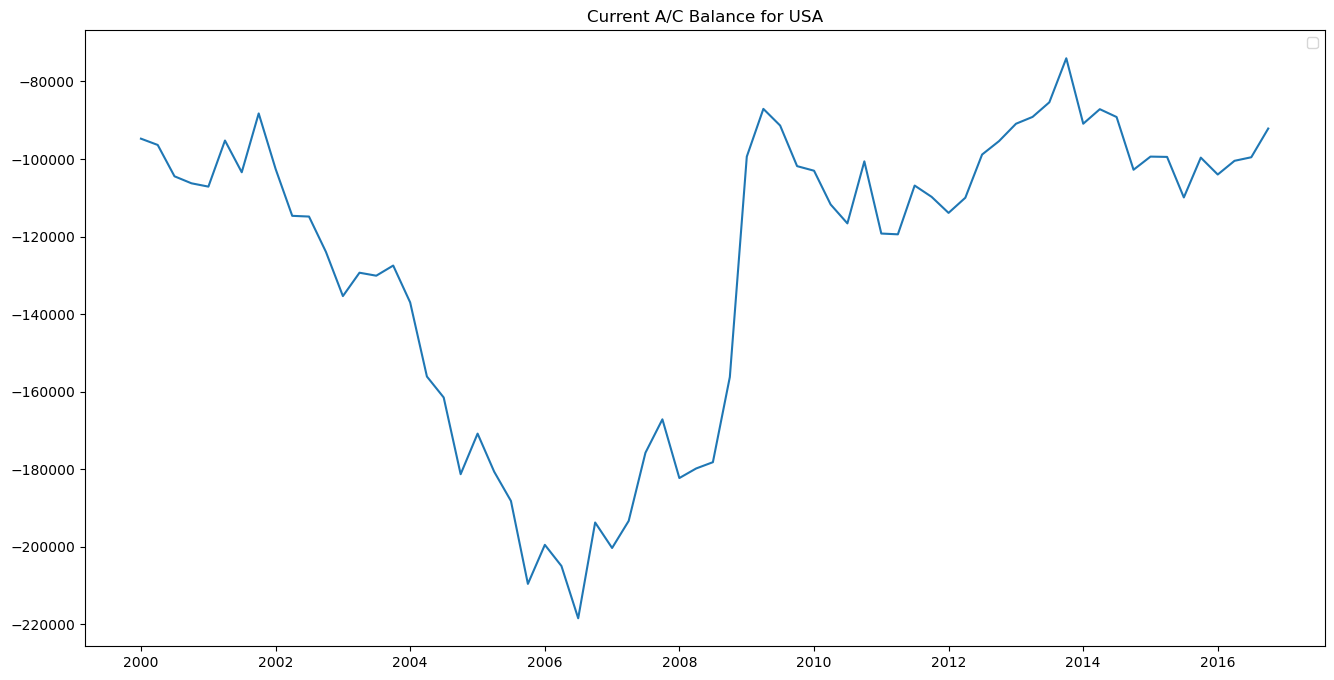

In [36]:
#Visualising Current A/C Balance for USA
plt.figure(figsize = (16, 8))
plt.plot(data["USA CAB"])
plt.title("Current A/C Balance for USA")
plt.legend()

In [37]:
#Splitting data into training and testing subsets

len_train = int(len(data)*0.7)
train_data = data[:len_train]
test_data = data[len_train:]

### Kalman Filter: Hyperparameter Optimization

In [38]:
# specify candidate values for hyperparameters
ks = np.linspace(.01, .99, 10)
zs = np.linspace(.01, 3, 10)
ws = np.arange(2,10)
hs = np.arange(1,8)

import itertools as it
# build a grid with all possible hyperparameters
grid = np.array(np.meshgrid(ks,zs, ws, hs)).T.reshape(-1,4)

grid

array([[0.01      , 0.01      , 2.        , 1.        ],
       [0.01      , 0.34222222, 2.        , 1.        ],
       [0.01      , 0.67444444, 2.        , 1.        ],
       ...,
       [0.99      , 2.33555556, 9.        , 7.        ],
       [0.99      , 2.66777778, 9.        , 7.        ],
       [0.99      , 3.        , 9.        , 7.        ]])

In [ ]:
storage = pd.DataFrame(columns = ["k", "z", "w", "h", "profits"])
train_df_copy = train_data.copy()


for n in range(len(grid)):
    k,z,w,h= grid[n]
    train_df_copy["Filter"] = train_df_copy.Differential.ewm(alpha = k, adjust = False).mean()

# Compute the filter error
    train_df_copy["Filter Error"] = train_df_copy.Differential - train_df_copy["Filter"]

# compute the rolling standard deviation
    train_df_copy["std"] = train_df_copy["Filter Error"].rolling(int(w)).std()

# create our confidence intervals or "boundaries of inaction"
# these are scaled by teh number of standard deviations "z"
    train_df_copy["Upper"] = train_df_copy["Filter"] + z*train_df_copy["std"]
    train_df_copy["Lower"] = train_df_copy["Filter"] - z*train_df_copy["std"]

# Create signal that evaluates whether we are outside the threshold
# then multiply by the direction of the mistake
# (we use economic theory to decide which direction is long or short)
    train_df_copy["test"] = np.where(train_df_copy["Filter Error"].abs()>z*train_df_copy["std"], -1, 0)*np.sign(train_df_copy["Filter Error"])
    train_df_copy["test2"] = 0
    train_df_copy["signal"] = 0
                                                                                                               
     # create vectors where we can store information on signals and when the change is first signalled
    
    
    for j in train_df_copy.index:
        # if there is a change in the signal, we want to take a position for teh next h periods
        if (train_df_copy.loc[j, "test"] == 1) &  (train_df_copy.shift().loc[j, "test"] != 1):
            train_df_copy.loc[j:j+datetime.timedelta(h), "signal"] = 1
            train_df_copy.loc[j, "test2"] = 1
        elif (train_df_copy.loc[j, "test"] == -1) &  (train_df_copy.shift().loc[j, "test"] != -1):
            train_df_copy.loc[j:j+datetime.timedelta(h), "signal"] =  -1
            train_df_copy.loc[j, "test2"] = -1
    
    # calculate metric
    train_df_copy["cumulative_returns"] = np.exp((train_df_copy["signal"].shift()*train_df_copy.Returns).cumsum())-1
    
    # store the results
    storage = storage.append({"k":k, "z":z, "w":w, "h":h,
                "profits":train_df_copy["cumulative_returns"][-1]}, ignore_index = True)
    
    # print so I can track progress of loop (can take a few minutes)

    # print(n)

In [40]:
storage = storage.sort_values(by = "profits").reset_index(drop = True)
storage

,k,z,w,h,profits
0,0.227778,0.342222,3.0,5.0,-0.225397
1,0.227778,0.342222,3.0,4.0,-0.225397
2,0.227778,0.342222,3.0,1.0,-0.225397
3,0.227778,0.342222,3.0,6.0,-0.225397
4,0.227778,0.342222,3.0,3.0,-0.225397
...,...,...,...,...,...
5595,0.990000,0.674444,3.0,6.0,0.482170
5596,0.990000,0.674444,3.0,5.0,0.482170
5597,0.990000,0.674444,3.0,1.0,0.482170
5598,0.990000,0.674444,3.0,4.0,0.482170


Text(0.5, 1.0, 'k optimization')

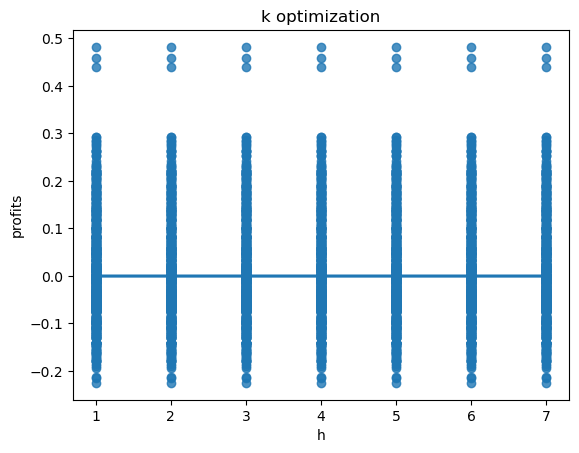

In [41]:
#Visualizing profits and different values of the holding period
sns.regplot(data = storage, x = "h", y = "profits", lowess = True)
plt.title("k optimization")

In [42]:
#Value of h doesn't affect profits; we can take h=1 

In [43]:
#Creating a function for heatmaps 
def heatmap(x, y, metric, values):
    
    # specify the columns I will be pulling from the results
    p2p = values[[x, y, metric]]
    
    # If p > 2, we need to group 
    heat = np.round(p2p.groupby([x,y]).max(),1)
    heat = heat.unstack()[metric]

    # round labels
    heat.index = np.round(heat.index,2)
    heat.columns = np.round(heat.columns,2)

    # make plot
    f, ax = plt.subplots(figsize=(25, 12))
    ax = sns.heatmap(heat, fmt='.1g')
    ax.set_title("Heat map of "+ metric,size = 18)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel(y, size = 18)
    ax.set_ylabel(x, size = 18)
    ax.collections[0].colorbar.set_label(metric, size = 18)
    sns.set(font_scale=1)
    plt.show()

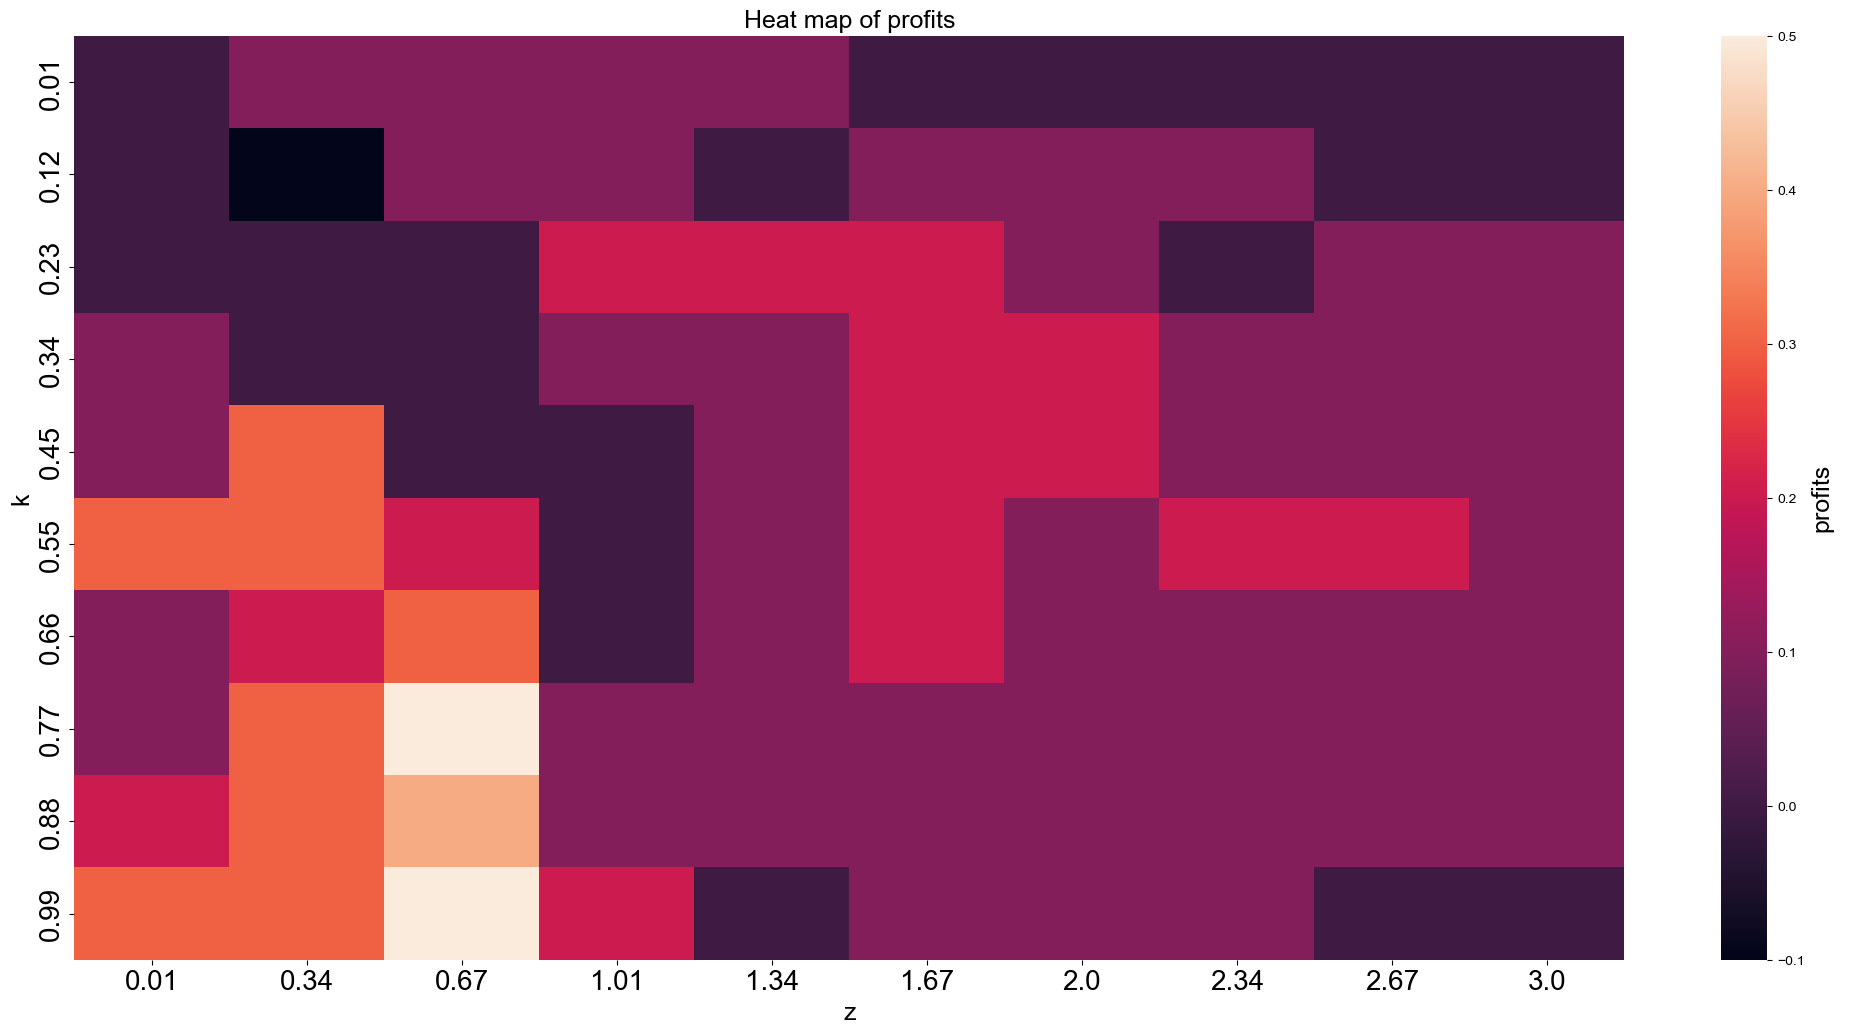

In [44]:
#Generating a heatmap for values of k and z
heatmap("k", "z","profits", storage)

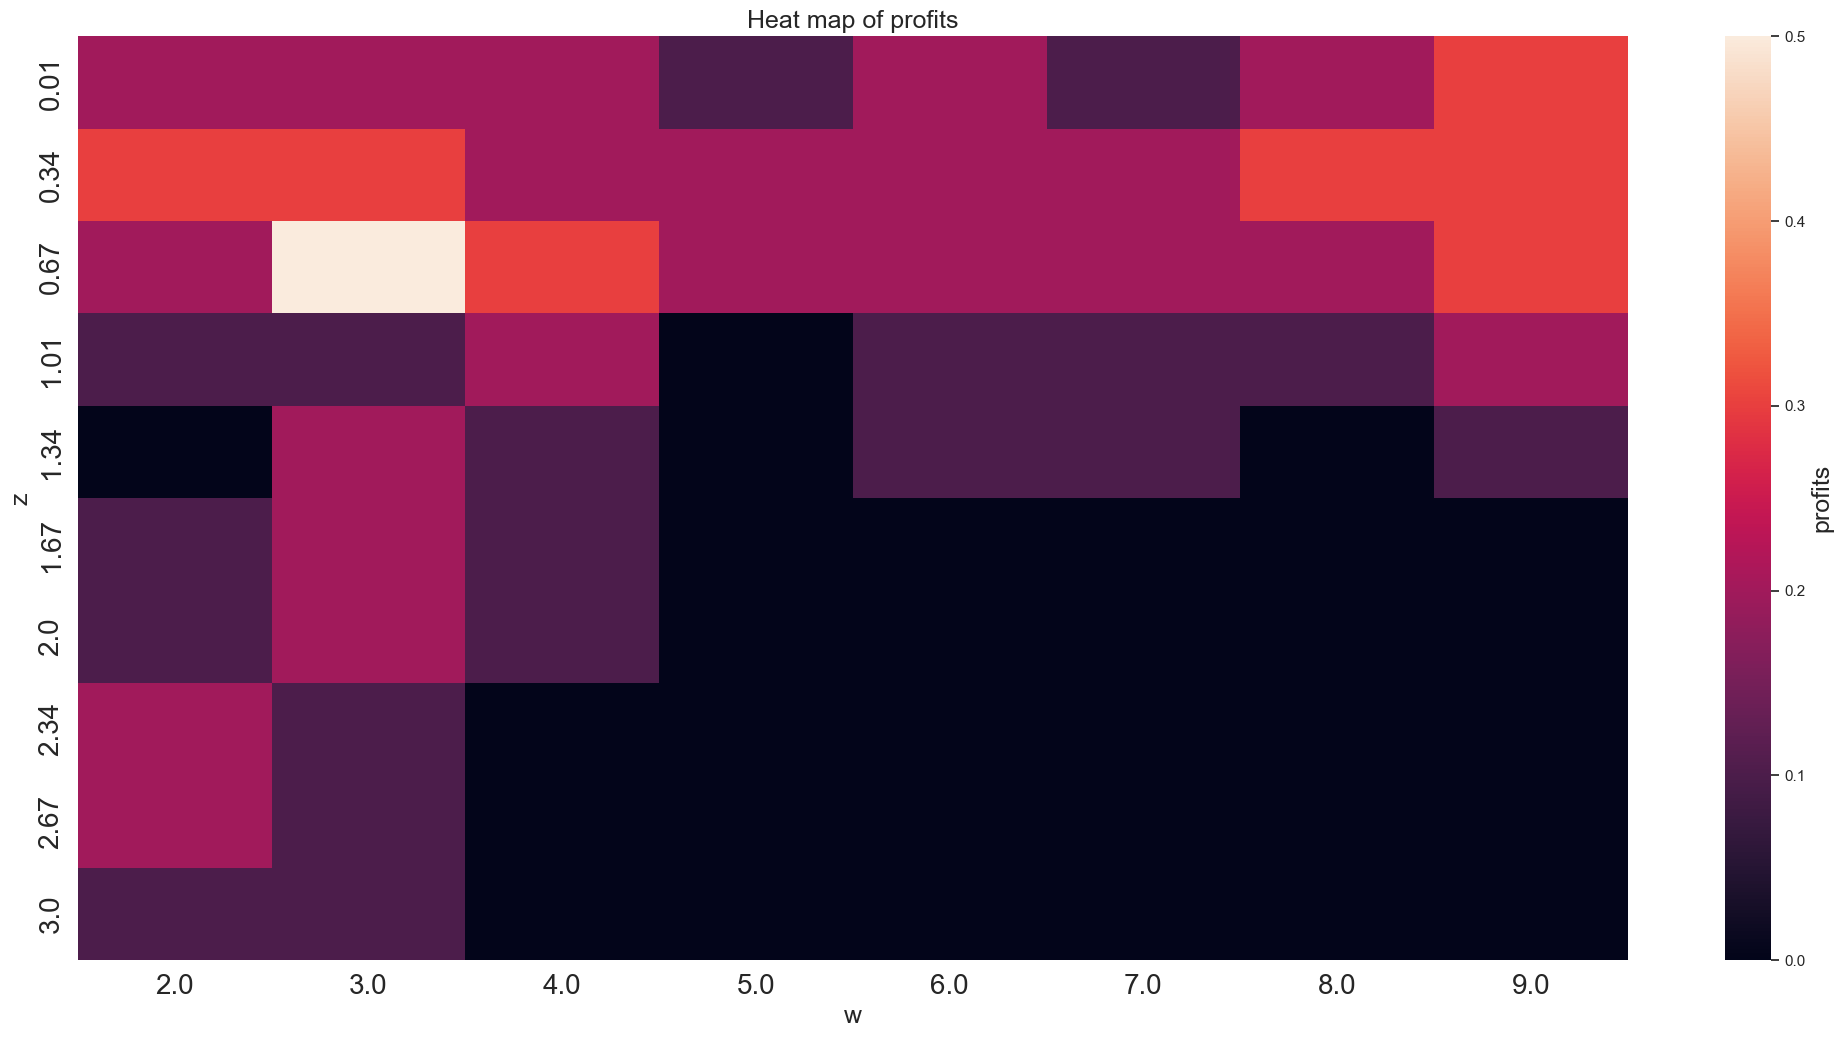

In [45]:
#Generating a heatmap for values of w and z
heatmap("z", "w","profits", storage)

In [46]:
#Optimal values
k,z,w, h, p = storage.iloc[-1]
k,z,w, h, p = (0.99, 0.6744444444444445, 3.0, 1.0, 0.4821697636153828)
#We choose h = 1

In [47]:
#Applying strategy to training data

storage = pd.DataFrame(columns = ["k", "z", "w", "h", "profits"])

train_df_copy["Filter"] = train_df_copy["Differential"].ewm(alpha = k, adjust = False).mean()
train_df_copy["Filter Error"] = train_df_copy["Differential"] -train_df_copy["Filter"]
train_df_copy["std"] = train_df_copy["Filter Error"].rolling(int(w)).std()
train_df_copy["Upper"] = train_df_copy["Filter"] + z*train_df_copy["std"]
train_df_copy["Lower"] = train_df_copy["Filter"] - z*train_df_copy["std"]

train_df_copy["test"] = np.where(train_df_copy["Filter Error"].abs()>z*train_df_copy["std"], 1, 0)*np.sign(train_df_copy["Filter Error"])


In [48]:
train_df_copy["test2"] = 0
train_df_copy["signal"] = 0
for j in train_df_copy.index:
    if (train_df_copy.loc[j, "test"] == 1) &  (train_df_copy.shift().loc[j, "test"] != 1):
        train_df_copy.loc[j:j+datetime.timedelta(h), "signal"] = 1
        train_df_copy.loc[j, "test2"] = 1
    elif (train_df_copy.loc[j, "test"] == -1) &  (train_df_copy.shift().loc[j, "test"] != -1):
        train_df_copy.loc[j:j+datetime.timedelta(h), "signal"] =  -1
        train_df_copy.loc[j, "test2"] = -1
train_df_copy["cumulative_returns"] = np.exp((train_df_copy["signal"].shift()*train_df_copy.Returns).cumsum())-1
train_df_copy["strat_returns"] = train_df_copy["signal"].shift()*train_df_copy.Returns

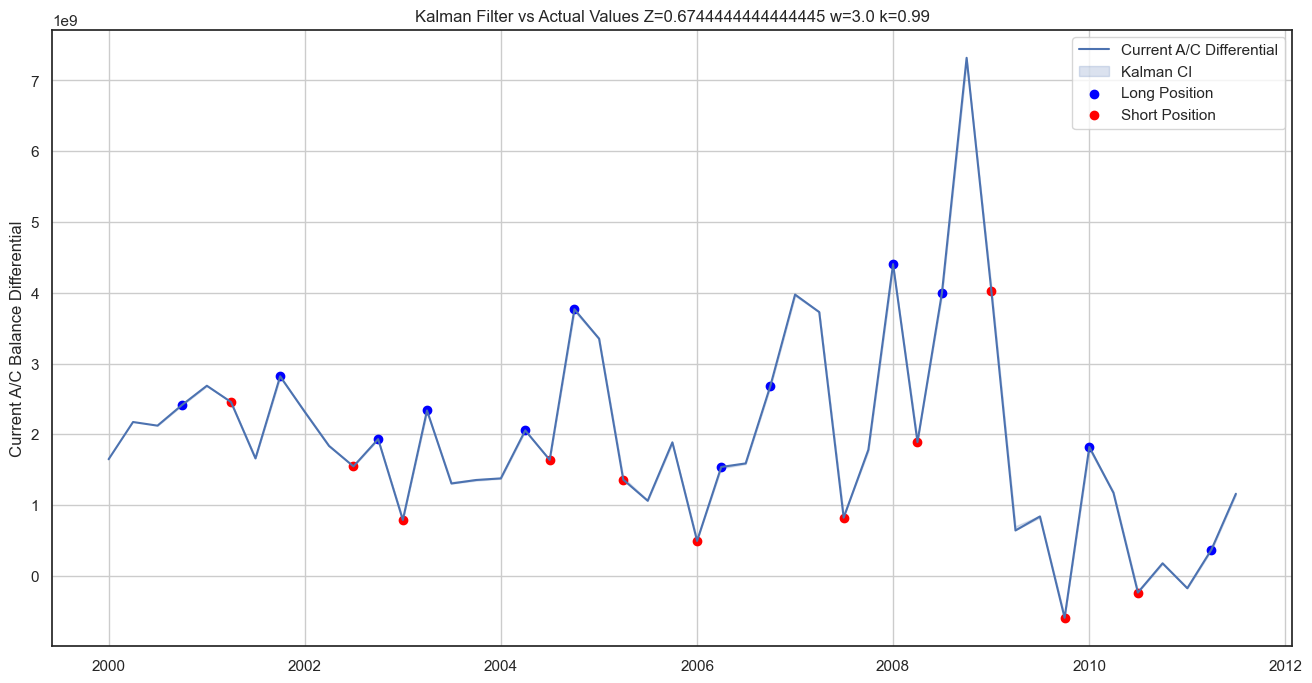

In [49]:
#Visualizing training data strategy

sns.set_style("white")
fig, ax = plt.subplots(figsize = (16, 8))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Current A/C Balance Differential")
ax.plot(train_df_copy["Differential"])
#ax.plot(df_copy["Filter"])


ax.fill_between(train_df_copy.index, train_df_copy.Lower, train_df_copy.Upper, color='b', alpha=.2)
ax.scatter(train_df_copy[train_df_copy.test2 == 1].index, train_df_copy[train_df_copy.test2 == 1]["Differential"], 
           color = "blue")
ax.scatter(train_df_copy[train_df_copy.test2 == -1].index, train_df_copy[train_df_copy.test2 == -1]["Differential"], 
           color = "red")

#ax.axvline(df_copy.index[-5], color = "red", linestyle = '--')
ax.legend(["Current A/C Differential", "Kalman CI", "Long Position", "Short Position"])


#plt.xlim([datetime.date(2000, 1, 1), datetime.date(2004, 1, 1)])
ax.grid()

In [50]:
train_df_copy["success"] = ((train_df_copy[train_df_copy.test2 != 0]["cumulative_returns"].diff()>0)*1).shift(-1)

/var/folders/1d/l6tryydj5ll_81bf6qw66y1m0000gn/T/ipykernel_67950/66199896.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shortsuccess = train_df_copy[(test_df_copy["success"] == 1) & (train_df_copy["test2"] == -1)]


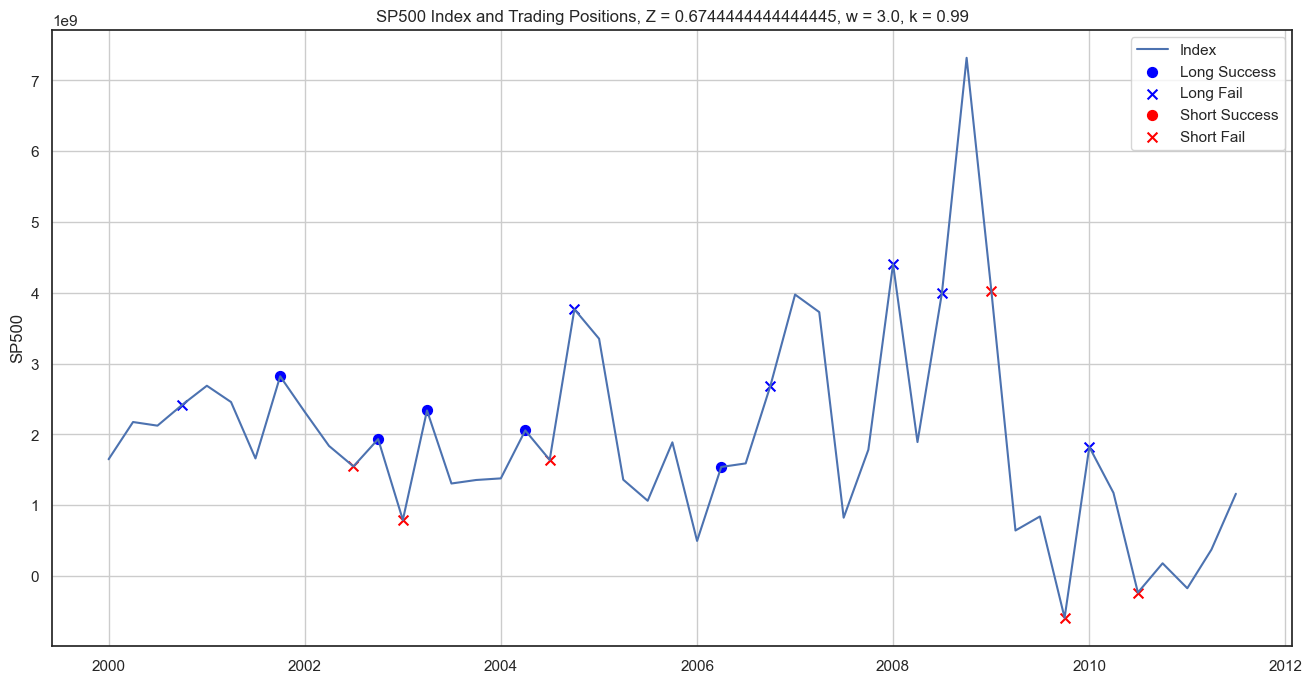

In [61]:
#Visualizing success and failure of our strategy-- training data

plt.figure(figsize = (16, 8))

plt.title("SP500 Index and Trading Positions"+ ", Z = "+str(z) + ", w = " + str(w)+ ", k = " + str(k))
plt.ylabel("SP500")
plt.plot(train_df_copy["Differential"])

longsuccess = train_df_copy[(train_df_copy["success"] == 1) & (train_df_copy["test2"] == 1)]
longfail = train_df_copy[(train_df_copy["success"] == 0) & (train_df_copy["test2"] == 1)] 
shortsuccess = train_df_copy[(test_df_copy["success"] == 1) & (train_df_copy["test2"] == -1)]
shortfail = train_df_copy[(train_df_copy["success"] == 0) & (train_df_copy["test2"] == -1)]

plt.scatter(longsuccess.index, longsuccess["Differential"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["Differential"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["Differential"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["Differential"], color = 'red', s = 50, marker = "x")

plt.legend(["Index", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

### Testing the Strategy

In [57]:
#Applying strategy to testing data

storage = pd.DataFrame(columns = ["k", "z", "w", "h", "profits"])
test_df_copy = test_data.copy()

test_df_copy["Filter"] = test_df_copy["Differential"].ewm(alpha = k, adjust = False).mean()
test_df_copy["Filter Error"] = test_df_copy["Differential"] -test_df_copy["Filter"]
test_df_copy["std"] = test_df_copy["Filter Error"].rolling(int(w)).std()
test_df_copy["Upper"] = test_df_copy["Filter"] + z*test_df_copy["std"]
test_df_copy["Lower"] = test_df_copy["Filter"] - z*test_df_copy["std"]

test_df_copy["test"] = np.where(test_df_copy["Filter Error"].abs()>z*test_df_copy["std"], 1, 0)*np.sign(test_df_copy["Filter Error"])

In [58]:
test_df_copy["test2"] = 0
test_df_copy["signal"] = 0
for j in test_df_copy.index:
    if (test_df_copy.loc[j, "test"] == 1) &  (test_df_copy.shift().loc[j, "test"] != 1):
        test_df_copy.loc[j:j+datetime.timedelta(h), "signal"] = 1
        test_df_copy.loc[j, "test2"] = 1
    elif (test_df_copy.loc[j, "test"] == -1) &  (test_df_copy.shift().loc[j, "test"] != -1):
        test_df_copy.loc[j:j+datetime.timedelta(h), "signal"] =  -1
        test_df_copy.loc[j, "test2"] = -1
test_df_copy["cumulative_returns"] = np.exp((test_df_copy["signal"].shift()*test_df_copy.Returns).cumsum())-1
test_df_copy["strat_returns"] = test_df_copy["signal"].shift()*test_df_copy.Returns

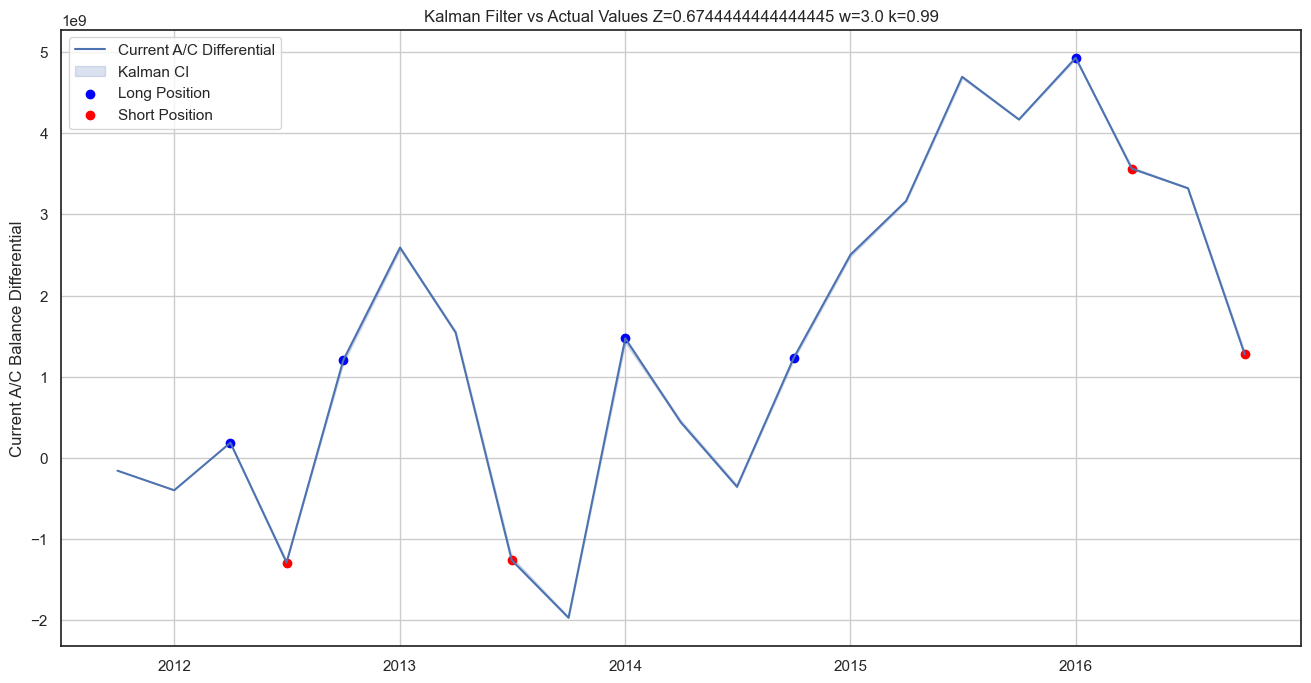

In [59]:
#Visualizing our strategy over testing data

sns.set_style("white")
fig, ax = plt.subplots(figsize = (16, 8))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Current A/C Balance Differential")
ax.plot(test_df_copy["Differential"])
#ax.plot(df_copy["Filter"])


ax.fill_between(test_df_copy.index, test_df_copy.Lower, test_df_copy.Upper, color='b', alpha=.2)
ax.scatter(test_df_copy[test_df_copy.test2 == 1].index, test_df_copy[test_df_copy.test2 == 1]["Differential"], 
           color = "blue")
ax.scatter(test_df_copy[test_df_copy.test2 == -1].index, test_df_copy[test_df_copy.test2 == -1]["Differential"], 
           color = "red")

#ax.axvline(df_copy.index[-5], color = "red", linestyle = '--')
ax.legend(["Current A/C Differential", "Kalman CI", "Long Position", "Short Position"])


#plt.xlim([datetime.date(2000, 1, 1), datetime.date(2004, 1, 1)])
ax.grid()


In [60]:
test_df_copy["success"] = ((test_df_copy[test_df_copy.test2 != 0]["cumulative_returns"].diff()>0)*1).shift(-1)

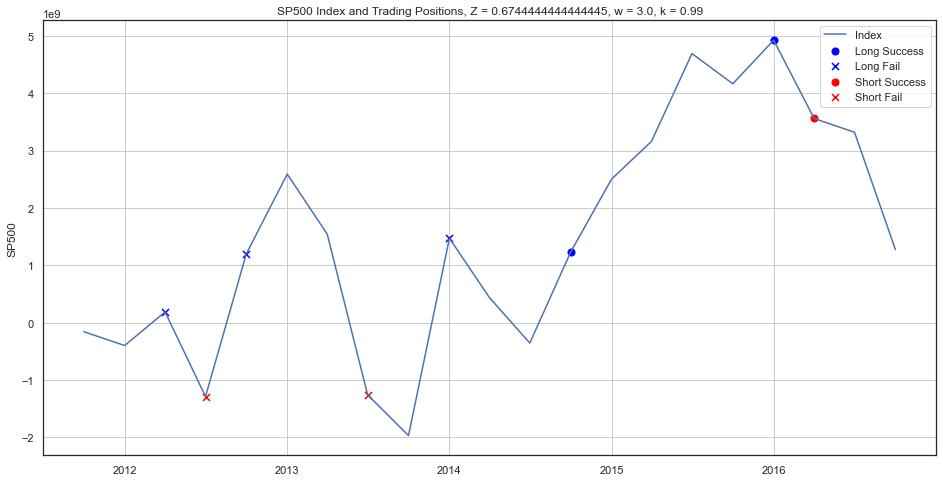

In [224]:
#Visualizing success and failure of our strategy-- testing data

plt.figure(figsize = (16, 8))

plt.title("SP500 Index and Trading Positions"+ ", Z = "+str(z) + ", w = " + str(w)+ ", k = " + str(k))
plt.ylabel("SP500")
plt.plot(test_df_copy["Differential"])

longsuccess = test_df_copy[(test_df_copy["success"] == 1) & (test_df_copy["test2"] == 1)]
longfail = test_df_copy[(test_df_copy["success"] == 0) & (test_df_copy["test2"] == 1)] 
shortsuccess = test_df_copy[(test_df_copy["success"] == 1) & (test_df_copy["test2"] == -1)]
shortfail = test_df_copy[(test_df_copy["success"] == 0) & (test_df_copy["test2"] == -1)]

plt.scatter(longsuccess.index, longsuccess["Differential"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["Differential"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["Differential"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["Differential"], color = 'red', s = 50, marker = "x")

plt.legend(["Index", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()


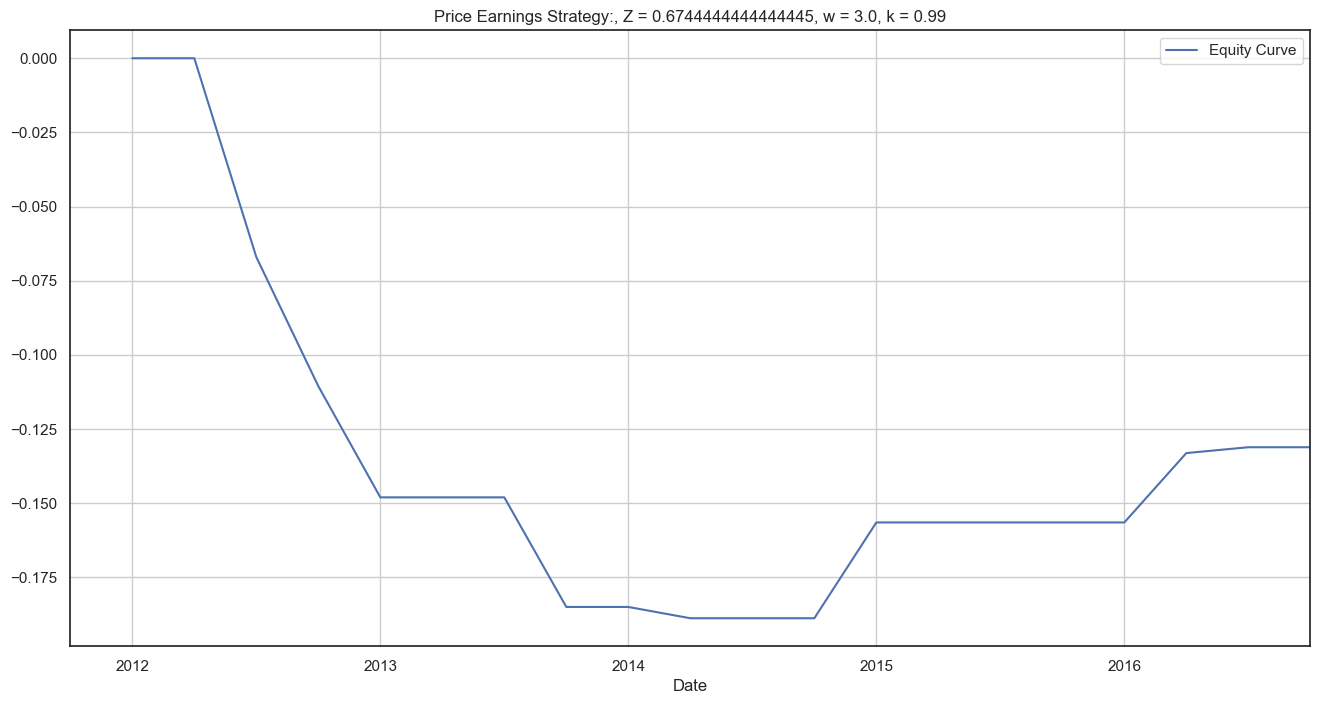

In [62]:
#Equity curve

plt.figure(figsize = (16, 8))
(test_df_copy["cumulative_returns"]).plot()

plt.title("ER Strategy:"+ ", Z = "+str(z) + ", w = " + str(w)+ ", k = " + str(k))

plt.legend(["Equity Curve"])

plt.grid()

### binomial test

In [67]:
# binomial test 
i = h
mret = str(i)+"_returns"  # concatenates i with returns and assigns the value to a new variable 
mret

'1.0_returns'

In [70]:
# make a new signal column

test_df_copy[str(i)+"_signal"] = 0   # adds a new column and assigns value 0 
for j in test_df_copy.index:
    if test_df_copy.loc[j,"signal"] != 0:
        test_df_copy.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = test_df_copy.loc[j, "signal"]   # if value is signal column is not 0 then it assigns that value to the new column

In [72]:
s=i
test_df_copy[str(s)+"_returns"] = (np.exp((test_df_copy[str(i)+"_signal"].shift()*test_df_copy.Returns).cumsum())-1)

# creates a new return column 

In [74]:
test_df_copy[str(s)+"_success"] = ((test_df_copy[test_df_copy.signal!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

# creates a new success column 

In [128]:
# create a new dataframe with relevatn columns from test_df_copy

df1 = test_df_copy[["1.0_signal", "MEX CAB"]].copy()
df1['D'] = df1["1.0_signal"]

In [ ]:
# make the index of the 2 datasets same 

df1.index = df1.index.tz_localize('US/Eastern')
test_df_copy.index = test_df_copy.index.tz_localize('US/Eastern')


In [153]:
df1['s_current'] = test_df_copy[test_df_copy.index.isin(df1.index)]["MEX CAB"].values

In [144]:
import pandas as pd
# shifting by 1 since our holding period is only 1 quarter

df1['s_future'] = df1['MEX CAB'].shift(1)

In [154]:
# Get the realized exchange rate

df1['R'] = np.where(df1['s_future'] >= df1['s_current'], 1, -1)

In [155]:
## Sample Covariance
df1['W'] = (df1['D']-np.mean(df1['D']))*(df1['R']-np.mean(df1['R']))
T_B = np.mean(df1['W'])

In [156]:
T_B

0.43537414965986376

In [157]:
## Newey-West LRV estimator
dy = df1['W'] - np.mean(df1['W'])
gamma_0 = sum((dy)**2)/len(df1)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df1)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [158]:
## Test-statistic
from scipy.stats import norm

statistic = T_B/np.sqrt(LRV/df1.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  4.267298905933181 , 5 % critical value :  1.64


#### we reject the null hypothesis: it suggests that our directional forecasts successfully captured the realized appreciation or depreciation of exchange rates.

### (i) geometric average quarterly 

In [163]:
# number of periods we have 
t = len(test_df_copy['MEX CAB'])
t

21

In [172]:
# Calculate the geometric mean of the quarterly returns
# we will use cummulative returns as the basis 

geometric_mean = (1 + test_df_copy['cumulative_returns']).prod()**(1/len(test_df_copy['cumulative_returns'])) - 1
print("the geometric average quarterly return is:", geometric_mean)

the geometric average quarterly return is: -0.13228158834039871


In [174]:
# explanation:

# For example, suppose we have quarterly returns of 2%, 3%, and 1%. 
# Adding 1 to each of these returns gives us 1.02, 1.03, and 1.01, respectively. 
# Taking the product of these adjusted returns gives us 1.067206. 
# Taking the cube root of this result (since we have three quarterly returns) gives us 1.02136, which represents the average quarterly return. 
# Subtracting 1 from this result gives us 0.02136, which is the geometric mean return.

### (ii) standard deviation

In [182]:
std = test_df_copy['cumulative_returns'].std()*100
print("the standard deviation of return is:", std)

the standard deviation of return is: 5.532804540481403


### (iii) annualized return

In [180]:
P = 1000000

t = len(test_df_copy)/4.  # since 4 quarters in a year 
A = (test_df_copy["cumulative_returns"].iloc[-1]/100+1)*P
ann_ret = (((A/P)**(1/t))-1)*100
print("the annualized returns are:", ann_ret)

the annualized returns are: -0.02499689293028462


### (iv) annualized standard deviation 

In [183]:
# calculate the anualized standard deviation
ann_std = test_df_copy['cumulative_returns'].std()*np.sqrt(4)*100
print("the annualized standard deviation of return is:", ann_std)

the annualized standard deviation of return is: 11.065609080962806


### (v) risk free rate

In [184]:
# download data on the assumed risk free rate

rf_rate = pd.read_csv("1-year-treasury-rate-yield-chart.csv", index_col = 0, parse_dates = True).dropna()
rf_rate.head()

,interest
date,
2062-01-02,3.22
2062-01-03,3.24
2062-01-04,3.24
2062-01-05,3.26
2062-01-08,3.31


In [230]:
rf_rate.index = rf_rate.index.tz_localize('UTC').tz_convert('US/Eastern')

In [232]:
# get quarterly data
rf_rate_quaterly = rf_rate.resample('Q').mean()

In [233]:
start_date = '2011-12-31'
end_date = '2016-12-31'
rf_rate_range = rf_rate_quaterly.loc[start_date:end_date]

In [234]:
rf_rate_range

,interest
date,
2011-12-31 00:00:00-05:00,0.113934
2012-03-31 00:00:00-04:00,0.156452
2012-06-30 00:00:00-04:00,0.188125
2012-09-30 00:00:00-04:00,0.181719
2012-12-31 00:00:00-05:00,0.172333
2013-03-31 00:00:00-04:00,0.149672
2013-06-30 00:00:00-04:00,0.128125
2013-09-30 00:00:00-04:00,0.121719
2013-12-31 00:00:00-05:00,0.125738


In [235]:
# fill null values 

test_df_copy["rf"] = rf_rate_range
test_df_copy

,USA CAB,MEX CAB,MEX ER,US ER,Differential,Returns,Filter,Filter Error,std,Upper,...,test,test2,signal,cumulative_returns,strat_returns,success,1.0_signal,1.0_returns,1.0_success,rf
2011-12-31 00:00:00-05:00,-109771.0,1.564000e+08,11.6294,1.0,-1.565098e+08,-0.017018,-1.565098e+08,0.000000e+00,NaN,NaN,...,0.0,0,0,NaN,NaN,NaN,0,NaN,NaN,0.113934
2012-03-31 00:00:00-04:00,-113912.0,3.972000e+08,13.8767,1.0,-3.973139e+08,0.176675,-3.949059e+08,-2.408041e+06,NaN,NaN,...,-0.0,0,0,0.000000,0.000000,NaN,0,0.000000,NaN,0.156452
2012-06-30 00:00:00-04:00,-110004.0,-1.880000e+08,13.6736,1.0,1.878900e+08,-0.014744,1.820620e+08,5.827959e+06,4.234687e+06,1.849181e+08,...,1.0,1,1,0.000000,-0.000000,0.0,1,0.000000,0.0,0.188125
2012-09-30 00:00:00-04:00,-98866.0,1.286500e+09,12.7569,1.0,-1.286599e+09,-0.069395,-1.271912e+09,-1.468661e+07,1.032346e+07,-1.264950e+09,...,-1.0,-1,-1,-0.067042,-0.069395,0.0,-1,-0.067042,0.0,0.181719
2012-12-31 00:00:00-05:00,-95400.0,-1.204500e+09,13.3813,1.0,1.204405e+09,0.047786,1.179641e+09,2.476317e+07,1.973016e+07,1.192948e+09,...,1.0,1,1,-0.110575,-0.047786,0.0,1,-0.110575,0.0,0.172333
2013-03-31 00:00:00-04:00,-90923.0,-2.591000e+09,12.8172,1.0,2.590909e+09,-0.043070,2.576796e+09,1.411268e+07,2.040881e+07,2.590561e+09,...,1.0,0,0,-0.148070,-0.043070,NaN,0,-0.148070,NaN,0.149672
2013-06-30 00:00:00-04:00,-89161.0,-1.544300e+09,12.7600,1.0,1.544211e+09,-0.004473,1.554537e+09,-1.032586e+07,1.799034e+07,1.566670e+09,...,-0.0,0,0,-0.148070,-0.000000,NaN,0,-0.148070,NaN,0.128125
2013-09-30 00:00:00-04:00,-85392.0,1.259100e+09,12.3404,1.0,-1.259185e+09,-0.033437,-1.231048e+09,-2.813722e+07,2.121140e+07,-1.216742e+09,...,-1.0,-1,-1,-0.148070,-0.000000,0.0,-1,-0.148070,0.0,0.121719
2013-12-31 00:00:00-05:00,-74041.0,1.967000e+09,12.9000,1.0,-1.967074e+09,0.044349,-1.959714e+09,-7.360259e+06,1.123775e+07,-1.952135e+09,...,-0.0,0,0,-0.185026,-0.044349,NaN,0,-0.185026,NaN,0.125738
2014-03-31 00:00:00-04:00,-90914.0,-1.473100e+09,13.1771,1.0,1.473009e+09,0.021253,1.438682e+09,3.432723e+07,3.181021e+07,1.460136e+09,...,1.0,1,1,-0.185026,0.000000,0.0,1,-0.185026,0.0,0.120645


### (vi) sharpe ratio 

In [201]:
# get annualized returns and standard deviation  

excess_return = test_df_copy["cumulative_returns"]- test_df_copy["rf"]
anualized_excess = ((excess_return+1).prod()**(1/t)-1)*100
excess_ann_std = excess_return.std()*np.sqrt(4)*100
print("the sharpe ratio is:", (anualized_excess)/excess_ann_std)


the sharpe ratio is: -2.3645889527691257


### regression

In [202]:
import yfinance as yf

In [209]:
# Download data for the S&P 500 index
spy = yf.Ticker("^GSPC")
snp = spy.history(period="max")
# Select only the closing price column
snp_close = snp[["Close"]]
snp_close.index = pd.to_datetime(snp_close.index)
snp_close
# convert closing price to returns
snp_close = snp_close.pct_change()
# get quarterly data
snp_quaterly = snp_close.resample('Q').mean()
snp_quaterly.dropna()

,Close
Date,
1928-03-31 00:00:00-05:00,0.001444
1928-06-30 00:00:00-04:00,-0.000050
1928-09-30 00:00:00-04:00,0.001608
1928-12-31 00:00:00-05:00,0.002333
1929-03-31 00:00:00-05:00,0.000869
...,...
2022-03-31 00:00:00-04:00,-0.000728
2022-06-30 00:00:00-04:00,-0.002736
2022-09-30 00:00:00-04:00,-0.000757


In [215]:
snp_quaterly.index = snp_quaterly.index.tz_convert('US/Eastern')

In [219]:
start_date = '2011-12-31'
end_date = '2016-12-31'
snp_quaterly_range = snp_quaterly.loc[start_date:end_date]

In [220]:
snp_quaterly_range

,Close
Date,
2011-12-31 00:00:00-05:00,0.001819
2012-03-31 00:00:00-04:00,0.001847
2012-06-30 00:00:00-04:00,-0.000479
2012-09-30 00:00:00-04:00,0.000916
2012-12-31 00:00:00-05:00,-0.000132
2013-03-31 00:00:00-04:00,0.001614
2013-06-30 00:00:00-04:00,0.000404
2013-09-30 00:00:00-04:00,0.000732
2013-12-31 00:00:00-05:00,0.001500


In [226]:
test_df_copy.index = test_df_copy.index.tz_localize('US/Eastern')


In [236]:
snp_rf = pd.merge(snp_quaterly_range, test_df_copy, left_index=True, right_index=True)
snp_rf

,Close,USA CAB,MEX CAB,MEX ER,US ER,Differential,Returns,Filter,Filter Error,std,...,test,test2,signal,cumulative_returns,strat_returns,success,1.0_signal,1.0_returns,1.0_success,rf
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-31 00:00:00-05:00,0.001819,-109771.0,1.564000e+08,11.6294,1.0,-1.565098e+08,-0.017018,-1.565098e+08,0.000000e+00,NaN,...,0.0,0,0,NaN,NaN,NaN,0,NaN,NaN,0.113934
2012-03-31 00:00:00-04:00,0.001847,-113912.0,3.972000e+08,13.8767,1.0,-3.973139e+08,0.176675,-3.949059e+08,-2.408041e+06,NaN,...,-0.0,0,0,0.000000,0.000000,NaN,0,0.000000,NaN,0.156452
2012-06-30 00:00:00-04:00,-0.000479,-110004.0,-1.880000e+08,13.6736,1.0,1.878900e+08,-0.014744,1.820620e+08,5.827959e+06,4.234687e+06,...,1.0,1,1,0.000000,-0.000000,0.0,1,0.000000,0.0,0.188125
2012-09-30 00:00:00-04:00,0.000916,-98866.0,1.286500e+09,12.7569,1.0,-1.286599e+09,-0.069395,-1.271912e+09,-1.468661e+07,1.032346e+07,...,-1.0,-1,-1,-0.067042,-0.069395,0.0,-1,-0.067042,0.0,0.181719
2012-12-31 00:00:00-05:00,-0.000132,-95400.0,-1.204500e+09,13.3813,1.0,1.204405e+09,0.047786,1.179641e+09,2.476317e+07,1.973016e+07,...,1.0,1,1,-0.110575,-0.047786,0.0,1,-0.110575,0.0,0.172333
2013-03-31 00:00:00-04:00,0.001614,-90923.0,-2.591000e+09,12.8172,1.0,2.590909e+09,-0.043070,2.576796e+09,1.411268e+07,2.040881e+07,...,1.0,0,0,-0.148070,-0.043070,NaN,0,-0.148070,NaN,0.149672
2013-06-30 00:00:00-04:00,0.000404,-89161.0,-1.544300e+09,12.7600,1.0,1.544211e+09,-0.004473,1.554537e+09,-1.032586e+07,1.799034e+07,...,-0.0,0,0,-0.148070,-0.000000,NaN,0,-0.148070,NaN,0.128125
2013-09-30 00:00:00-04:00,0.000732,-85392.0,1.259100e+09,12.3404,1.0,-1.259185e+09,-0.033437,-1.231048e+09,-2.813722e+07,2.121140e+07,...,-1.0,-1,-1,-0.148070,-0.000000,0.0,-1,-0.148070,0.0,0.121719
2013-12-31 00:00:00-05:00,0.001500,-74041.0,1.967000e+09,12.9000,1.0,-1.967074e+09,0.044349,-1.959714e+09,-7.360259e+06,1.123775e+07,...,-0.0,0,0,-0.185026,-0.044349,NaN,0,-0.185026,NaN,0.125738


In [237]:
# calculate excess returns 

snp_rf['excess_return'] = snp_rf['cumulative_returns'] - snp_rf['rf']
snp_rf['excess_market_return'] = snp_rf['Close'] - snp_rf['rf']

In [239]:
# run regression 

import statsmodels.formula.api as smf

mod = smf.ols('excess_return~excess_market_return', data = snp_rf).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     226.4
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           1.22e-11
Time:                        15:44:27   Log-Likelihood:                 30.041
No. Observations:                  20   AIC:                            -56.08
Df Residuals:                      18   BIC:                            -54.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1380      0.022     -6.264      0.000      -0.184      -0.092
excess_market_return     0.9976      0.066     15.047      0.000       0.858       1.137
==============================================================================
Omnibus:                       12.141   Durbin-Watson:                   0.191
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                9.758
Skew:                           1.537   Prob(JB):                      0.00761
Kurtosis:                       4.505   Cond. No.                         5.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### (i) alpha

In [257]:
alpha = str(mod.params[0])
print('Alpha for this strategy is:', alpha)

Alpha for this strategy is: -0.13797911166012428


### (ii) beta

In [241]:
print('Beta for this strategy is:', str(mod.params[1]))

Beta for this strategy is: 0.9975712983617879


### (iii) Up Alpha

In [243]:
### Up is when S&P500 yeilds a higher than 0% return 

# subset the data into obly positive S&P returns 

pos_snp = snp_rf[snp_rf.Close > 0]

In [247]:
mod1 = smf.ols('excess_return~excess_market_return', data = pos_snp).fit()
print('Up Alpha for this strategy is:', str(mod1.params[0]))

Up Alpha for this strategy is: -0.15230572681560686


### (iv) Up Beta

In [245]:
mod1 = smf.ols('excess_return~excess_market_return', data = pos_snp).fit()
print('Up Beta for this strategy is:', str(mod1.params[1]))

Up Beta for this strategy is: 0.9748269810254631


### (v) Up Rsquared 

In [248]:
print('Up Rsquared for this strategy is:', str(mod1.rsquared))

Up Rsquared for this strategy is: 0.9490695732218255


### (vi) Down Alpha 


In [249]:

### Down is when S&P500 yeilds a less than 0% return 

# subset the data into only negative S&P returns 

neg_snp = snp_rf[snp_rf.Close < 0]

In [250]:
mod2 = smf.ols('excess_return~excess_market_return', data = neg_snp).fit()

In [251]:
print('Down Alpha for this strategy is:', str(mod2.params[0]))

Down Alpha for this strategy is: 0.03310026466647717


### (vii) Down Beta

In [252]:
print('Down Beta for this strategy is:', str(mod2.params[1]))

Down Beta for this strategy is: 1.576958803575475


In [253]:
### (viii) Down Rsquared 
print('Down Rsquared for this strategy is:', str(mod2.rsquared))

Down Rsquared for this strategy is: 0.8280608668628736


In [264]:
# create a table with all indices 

# Create a list with the column data
data = [['Geo. Average Quarterly', geometric_mean],
        ['Std. Deviation', std],
        ['Annualized Return', ann_ret],
       ['Annualized Return', ann_std],
        ['Sharpe Ratio', (anualized_excess)/(excess_ann_std)],
        ['Alpha', str(mod.params[0])],
        ['Beta', str(mod.params[1])],
        ['Up Alpha', str(mod1.params[0])],
        ['Up Beta', str(mod1.params[1])],
        ['Up Rsquared', str(mod1.rsquared)],

        ['Down Alpha', str(mod2.params[0])],
        ['Down Beta', str(mod2.params[1])],
        ['Down Rsquared', str(mod2.rsquared)],
       
       ]

# Create the DataFrame
indices = pd.DataFrame(data, columns=['indices', 'values'])
indices

,indices,values
0,Geo. Average Quarterly,-0.132282
1,Std. Deviation,5.532805
2,Annualized Return,-0.024997
3,Annualized Return,11.065609
4,Sharpe Ratio,-2.364589
5,Alpha,-0.13797911166012428
6,Beta,0.9975712983617879
7,Up Alpha,-0.15230572681560686
8,Up Beta,0.9748269810254631
9,Up Rsquared,0.9490695732218255
